## Tensorflow Probability - Stress Testing Tensorflow Probability  
### Day 7/100 Days of TensorFlow Probability  

Yesterday, we used bootstrapping to determine uncertainty intervals for point predictions from `tfp.glm.fit()`. This certainly worked well. However, I didn't really embrace the TensorFlow paradigm yesterday. Instead I iterated over independent bootstrapped samples, applying the `fit()` method in each iteration.

One of tensorflow probability's big promises is speed and performance. This is largely due to embracing TensorFlow's "Tensor-In, Tensor-Out" pattern which allows operations to be vectorised and broadcast effectively. So today, I am going to explore this.

What does it take to re-factor yesterday's bootstrap into a tensor-operation?  
Howe well does this scale?

I will stress test this over an increasing large population of bootstrapped batches and benchmark three methods: 1) sklearn's `LinearRegression()` method, 2) `tfp.glm.fit()` using a list comprehension to loop through batches and 3) `tfp.glm.fit()` using tensor operations.


### Example data  

As always, let's start with some data. We'll use the same simulated dataset as we used yesterday:

[[ 0.40166528]
 [ 0.29879191]
 [-0.09915495]
 [ 2.5320589 ]]


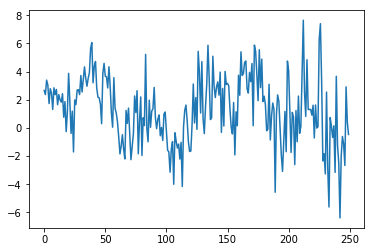

In [2]:
import collections
import numpy as np

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

import matplotlib.pyplot as plt

from __future__ import print_function


np.random.seed(1704)

# simulate 300 observations which follow a rough seasonal pattern
N = 250
X = np.transpose(
    np.matrix([
        np.ones(N),                                           # bias term 
        np.random.normal(2.7, 3, N),                          # feature one
        np.random.normal(-1.5, 1, N),                         # feature two
        0.45*np.cos(np.linspace(1, N, N) / 7.0) + \
            0.55*np.sin(np.linspace(1, N, N) / 21.0)          # seasonalilty
]))

# "ground truth" effects
# these are the parameters that we will attempt to recover
betas = np.matrix([
    np.random.normal(0.4, 0.1, N),                   # the intercept
    np.random.normal(0.3, 0.075, N),                    # effect of feature one
    np.random.normal(-0.1, 0.025, N),                  # effect of feature two
    np.random.normal(2.5, 0.75, N)                    # the seasonal effect
])
ground_truth_betas = np.mean(betas, axis=1)
print(ground_truth_betas)

# create a response variable, which is a function of our Xs + noise
y = np.mean(np.matmul(X, betas), axis=1)
y += np.random.normal(0, [0.15*np.sqrt(x) for x in range(N)], N)[:,np.newaxis]
y = tf.convert_to_tensor(y.reshape(N,)).numpy()[0]

plt.plot(range(N), y)
plt.show()

### Baseline model  

And just to remind ourselves, we estimated the following weights (and uncertainties) via bootstrapping yesterday:

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


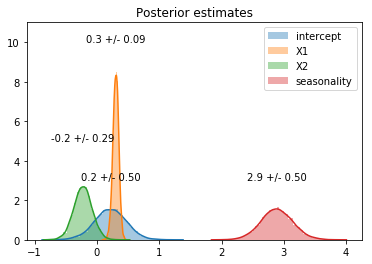

In [3]:
import seaborn as sns

def bootstrap(x, y, n = 80):
  idx = np.random.choice(x.shape[0], n, replace = True)
  
  return [np.array(x[idx, :]), np.array(y[idx])]

def train(bootstrap_data = []):
  
  x, y = bootstrap_data
  
  weights, yhat, is_converged, num_iter = tfp.glm.fit(
    model_matrix = x,
    response = y,
    model = tfp.glm.Normal()
  )
  
  return weights.numpy()


# split into training and test sets
xtrain, xtest = [X[:150,::], X[150:,::]]
ytrain, ytest = [y[:150], y[150:]]



# Bootstrapped estimates
K = 10000
bootstrap_weights = np.vstack([
    train(bootstrap(xtrain, ytrain)) for x in range(K)
])

# visualise the results
for i in range(bootstrap_weights.shape[1]):
  posterior = bootstrap_weights[:, i]
  
  label_ = 'intercept' if i == 0 else 'seasonality' if i == 3 else 'X{}'.format(i)
  sns.distplot(posterior, label = label_)
  plt.text(x = np.mean(posterior), y = [3, 10, 5, 3][i], 
           s = '{:.1f} +/- {:.2f}'.format(np.mean(posterior), 1.96*np.std(posterior)),
          horizontalalignment = 'center')
  plt.ylim((0, 11))


plt.legend()
plt.title("Posterior estimates")
plt.show()

### Refactoring as a tensor operation  

To do this, I need to go back and revisit tfp's shape semantics. A distribution has three slots which define it's shape:  

```
(sample_shape, batch_shape, event_shape)
```

Where,   
   - the `sample_shape` describes `n iid draws` from a distribution  
   - the `batch_shape` describes "independent, *not* identically distributed draws" ([Dillon, 2019](https://ai.google/research/pubs/pub46893/)). As we discussed in an earlier notebook, a shape of (100, 5, 1) might represent 100 iid samples from 5 different Poisson distributions (for example).  
   - the `event_shape` is the number of dimensions for each observation  
   
So, if we paraphrase this for our experiment here, then we want:  

  - `sample_shape`: `k iid bootstrapped` datasets (i.e. the number of batches that we will use to infer the uncertainty of our estimates)  
  - `batch_shape`: `n iid bootstrap samples` from our simulated data (i.e. each is a single bootstrapped dataset)  
  - `event_shape`: 4 (bias, feature one, feature two, seasonality).  
  
  
### Creating our tensors  

We can use `tf.stack()` (almost identicle to `np.stack()`) to create our tensors. Here is an example: we will create 5 different bootstrapped datasets, each with 80 observations sampled from our dataset, then stack these together to give a shape of `(5, 80, 4)`:

In [4]:
batches = [bootstrap(xtrain, ytrain) for _ in range(5)]
batch_tensors = tf.stack([x[0] for x in batches], axis = 0)

batch_tensors.shape

TensorShape([Dimension(5), Dimension(80), Dimension(4)])

Nice - this looks good! Just to reiterate, we have created: 5 bootstrapped datasets, each of which has 80 bootstrapped observations of size 4.  

The reason that the "batch size" (5 above) is in the first dimension is because it is this dimension which we want to iterate over to get a set of weights for each of them. Obviously, once we ramp this up, we can then combine these independent estimates to evaluate the uncertainties just like we did before.

OK, so this looks good yeah? Let's convince ourselves that we get very similar results:

In [6]:
batches = [bootstrap(xtrain, ytrain) for _ in range(10000)]
batch_tensors_x = tf.stack([x[0] for x in batches], axis = 0)
batch_tensors_y = tf.stack([y[1] for y in batches], axis = 0)

weights_tensors, yhat, is_converged, num_iter = tfp.glm.fit(
    model_matrix = batch_tensors_x,
    response = batch_tensors_y,
    model = tfp.glm.Normal()
)
weights_tensors.shape

TensorShape([Dimension(10000), Dimension(4)])

Great, again this looks like what I had expected. Let's plot the results against the previous results:

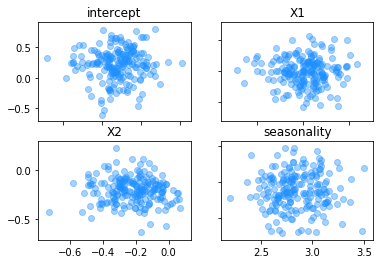

In [72]:
# visualise the results
fig, axs = plt.subplots(nrows=2,ncols=2)
for i in range(bootstrap_weights.shape[1]):
  
  posterior = bootstrap_weights[:, i]
  posterior_tensor = weights_tensors.numpy()[:, i]
  
  label_ = 'intercept' if i == 0 else 'seasonality' if i == 3 else 'X{}'.format(i)
  
  idx = [[0,0], [0,1], [1,0], [1,1]][i]
  axs[idx[0], idx[1]].scatter(np.random.choice(posterior, 200), np.random.choice(posterior_tensor, 200),
             color='dodgerblue', alpha=0.4, label = label_)

  axs[idx[0], idx[1]].set_title(label_)

for ax in axs.flat:
  ax.label_outer()
  
plt.xticks()
plt.xlabel(None)
plt.show()

These look pretty much identicle! Note, if these two "methods" came up with the same, or similar, answers then the point clouds above should be roughyl circular. If the methods differ in their results, then the point clouds would be elongated or even completely separated. But these look good.

### Performance Testing  

OK, so given that the results look pretty much the same - let's see what the performance is like. Keeping in mind that tfp's big claim is that tensor operations are meant to be increbily fast... So let's see.

I am going to benchmark sklearn's `LinearRegression()` method against tfp. For tfp, we will benchmark iteration via list comprehension vs. iteration via vectorisation over the tensors. Our benchmarks will run over increasingly large batch sizes (from 10 through to 100K). 

(p.s. I get that the code below isn't very pretty :p )

In [73]:
import timeit
import pandas as pd

#### create a large set of data
batches = [bootstrap(xtrain, ytrain) for _ in range(100000)]
batch_tensors_x = tf.stack([x[0] for x in batches], axis = 0)
batch_tensors_y = tf.stack([y[1] for y in batches], axis = 0)

#### create a data frame to collect the results
results = pd.DataFrame({
    'SIZE': [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000],
    'sklearn': 0,
    'tfp_list_comprehension': 0,
    'tfp_tensor': 0
})


#### Off we go!
for SIZE in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000, 100000]:
  
  #### sklearn
  #### Iterates over individual bootstrapped batches up to SIZE batches
  t1 = timeit.timeit(
      setup = """import tensorflow_probability as tfp; import numpy as np; from sklearn.linear_model import LinearRegression; from __main__ import batch_tensors_x, batch_tensors_y, train, SIZE;""",
      stmt = """model = LinearRegression();[model.fit(batch_tensors_x[x].numpy(),batch_tensors_y[x].numpy()) for x in range(SIZE)]""",
      number=1
  )
  
  #### list comprehension over single batches
  #### Iterates over individual bootstrapped batches up to SIZE batches
  t2 = timeit.timeit(
      setup = """import tensorflow_probability as tfp; import numpy as np; from sklearn.linear_model import LinearRegression; from __main__ import batch_tensors_x, batch_tensors_y, train, SIZE;""",
      stmt = """weights = np.vstack([
                    train([batch_tensors_x[x], batch_tensors_y[x]]) for x in range(SIZE)
                ])""",
      number=1
  )


  #### Tensor representation
  #### Batches are arranged in a single tensor with size: 
  #### (SIZE batches, 80 observations per batch, 4 features)
  t3 = timeit.timeit(
      setup = """import tensorflow_probability as tfp; import numpy as np; from sklearn.linear_model import LinearRegression; from __main__ import batch_tensors_x, batch_tensors_y, train, SIZE;""",
      stmt = """weights, yhat, is_converged, num_iter = tfp.glm.fit(
                  model_matrix = batch_tensors_x[:SIZE],
                  response = batch_tensors_y[:SIZE],
                  model = tfp.glm.Normal()
              )""", 
      number=1
  )

  results.loc[results.SIZE == SIZE, 'sklearn'] = t1
  results.loc[results.SIZE == SIZE, 'tfp_list_comprehension'] = t2
  results.loc[results.SIZE == SIZE, 'tfp_tensor'] = t3
  
  print(SIZE, t1, t2, t3)

10 0.01085936800154741 0.07017370799803757 0.007761135999317048
20 0.01591958000062732 0.1354872060001071 0.007271869999385672
50 0.04455931799748214 0.34260376499878475 0.007473253001080593
100 0.0785716099999263 0.6997916720029025 0.009695041000668425
200 0.17236766199857811 1.3912436020000314 0.010896812000282807
500 0.40741205000085756 3.386181188001501 0.015294112999981735
1000 0.7907867659996555 6.811613779998879 0.024921292999351863
2000 1.5253967639982875 13.548977365997416 0.03832371799944667
5000 3.896104863997607 34.11981849299991 0.08376608699836652
10000 7.851028723998752 67.34519053999975 0.1255968599980406
20000 15.485809522997442 135.05056497199985 0.2571142870001495
50000 38.932240278998506 342.742436337001 0.7229192289996718
100000 78.07557485199868 694.1712940940015 1.7717970019984932


In [74]:
results

,SIZE,sklearn,tfp_list_comprehension,tfp_tensor
0,10,0.010859,0.070174,0.007761
1,20,0.015920,0.135487,0.007272
2,50,0.044559,0.342604,0.007473
3,100,0.078572,0.699792,0.009695
4,200,0.172368,1.391244,0.010897
5,500,0.407412,3.386181,0.015294
6,1000,0.790787,6.811614,0.024921
7,2000,1.525397,13.548977,0.038324
8,5000,3.896105,34.119818,0.083766
9,10000,7.851029,67.345191,0.125597


Text(0, 0.5, 'Execution time (log(seconds))')

<Figure size 432x288 with 0 Axes>

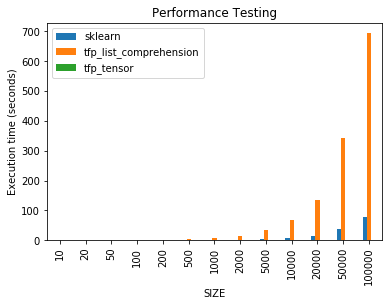

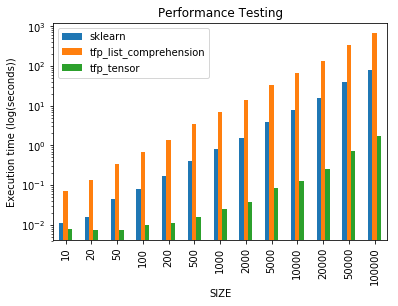

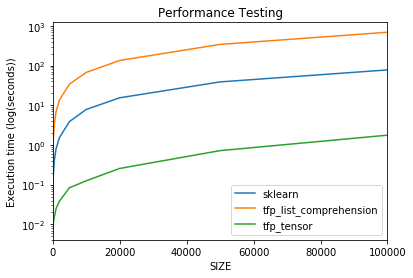

In [85]:
chart_title = "Performance Testing"

plt.figure()
results.plot(x = 'SIZE', y = ['sklearn', 'tfp_list_comprehension', 'tfp_tensor'], kind='bar', title=chart_title)
plt.ylabel("Execution time (seconds)")

results.plot(x = 'SIZE', y = ['sklearn', 'tfp_list_comprehension', 'tfp_tensor'], kind='bar', logy=True, title=chart_title)
plt.ylabel("Execution time (log(seconds))")

results.plot(x = 'SIZE', y = ['sklearn', 'tfp_list_comprehension', 'tfp_tensor'], logy=True, title=chart_title)
plt.ylabel("Execution time (log(seconds))")

That's impressive! This is a big moment on my journey here. So far, I haven't grappled with the full-on syntax of tensorflow-probability and if the performance wasn't amazing, I might have just decided to stick with Stan. **But look at this!!!!** Wow.